# Simulation to evaluate the reason of inflation

1. Take the chromosome-wide simulation in 1st experiment.
2. Perform a GWAS on the data.
3. Perform clumping on the data.
4. Run heterogeneity test on the index SNPs.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join

In [2]:
GENO_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr"
)
SIM_PHENO_DIR = "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/01_genome_wide_simulate/out/pheno"

In [3]:
def submit_gwas(prefix, sim_i):

    df_sample_info = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv"), sep="\t", index_col=0
    )
    out_prefix = f"out/simulated_gwas/{prefix}.sim_{sim_i}"

    admix.tools.plink2_gwas(
        pfile=join(GENO_DIR, f"imputed/chr22"),
        df_sample_info=df_sample_info,
        pheno_col=f"SIM_{sim_i}",
        out_prefix=out_prefix,
        clean_tmp_file=True,
    )
    admix.tools.plink2_clump(
        pfile=join(GENO_DIR, f"imputed/chr22"),
        assoc_path=out_prefix + ".assoc",
        out_prefix=out_prefix,
        p1=5e-8,
    )
    df_sample_info[[f"SIM_{sim_i}"]].rename(columns={f"SIM_{sim_i}": "trait"}).to_csv(
        out_prefix + ".pheno", sep="\t"
    )

In [4]:
prefix = "hsq-0.1-pcausal-0.001-cor-1.0-hermodel-mafukb"
sim_i = 3

submit_gwas(prefix, sim_i)

--pfile /u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr/imputed/chr22
--pheno out/simulated_gwas/hsq-0.1-pcausal-0.001-cor-1.0-hermodel-mafukb.sim_3.plink2_tmp_pheno
--linear hide-covar allow-no-covars
--out out/simulated_gwas/hsq-0.1-pcausal-0.001-cor-1.0-hermodel-mafukb.sim_3


In [5]:
df_pheno = pd.read_csv(
    f"out/simulated_gwas/{prefix}.sim_{sim_i}.pheno", sep="\t", index_col=0
)

df_assoc = pd.read_csv(
    f"out/simulated_gwas/{prefix}.sim_{sim_i}.assoc", delim_whitespace=True
)

# load clump
df_clump = pd.read_csv(
    f"out/simulated_gwas/{prefix}.sim_{sim_i}.clumped", delim_whitespace=True
)
df_assoc["HIT"] = df_assoc.ID.isin(df_clump.SNP)

# load beta
beta = np.load(join(SIM_PHENO_DIR, prefix + ".beta.npy"))[:, :, sim_i]
assert np.allclose(beta[:, 0], beta[:, 1])
beta = beta[:, 0]

df_assoc["SIM_BETA"] = beta
# dset_hm3 = admix.dataset.read_dataset(join(GENO_DIR, "hm3/chr22"))
# df_assoc = pd.merge(
#     df_assoc,
#     pd.DataFrame({"ID": dset_hm3.snp.index, "SIM_BETA": beta}),
#     left_on="ID",
#     right_on="ID",
#     how="left",
# )
# df_assoc["SIM_BETA"] = df_assoc["SIM_BETA"].fillna(value=0)

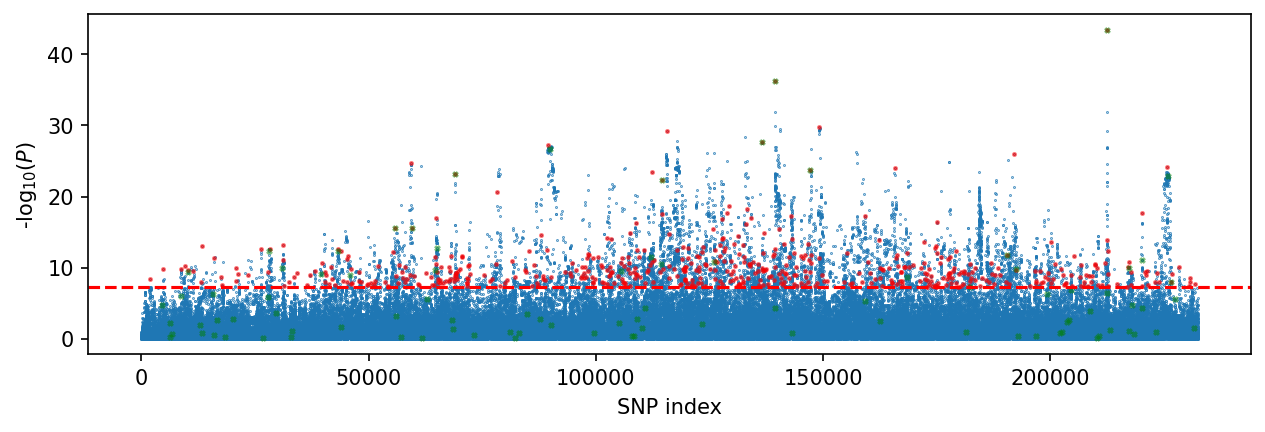

In [6]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
admix.plot.manhattan(df_assoc.P, ax=ax)

# plot GWAS hits
df_hit = df_assoc[df_assoc.HIT]
ax.scatter(df_hit.index.values, -np.log10(df_hit.P), s=2, alpha=0.5, color="r")

# plot groundtruth
df_gt = df_assoc[df_assoc.SIM_BETA != 0]
ax.scatter(
    df_gt.index.values, -np.log10(df_gt.P), s=5, alpha=0.5, marker="x", color="green"
)
fig.show()

In [7]:
# df_assoc_subset = df_assoc.iloc[0:3000, :].copy()
# fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
# admix.plot.manhattan(df_assoc_subset.P, ax=ax)

# # plot GWAS hits
# df_hit = df_assoc_subset[df_assoc_subset.HIT]
# ax.scatter(df_hit.index.values, -np.log10(df_hit.P), s=2, alpha=0.5, color="r")

# # plot groundtruth
# df_gt = df_assoc_subset[df_assoc_subset.SIM_BETA != 0]
# ax.scatter(
#     df_gt.index.values, -np.log10(df_gt.P), s=5, alpha=0.5, marker="x", color="green"
# )
# fig.show()

# Now evaluate the heterogeneity level of these GWAS hits

In [8]:
# Step 1: form data sets
# Step 2: assess heterogeneity

In [9]:
dset = admix.dataset.read_dataset(join(GENO_DIR, f"imputed/chr22"))
dset = dset[df_hit.ID.values]
apa = dset.allele_per_anc().compute()

admix.Dataset: `n_anc` is not provided, infered n_anc from the first 1,000 SNPs is 2. If this is not correct, provide `n_anc` when constructing admix.Dataset


In [10]:
import admix_genet_cor
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
df_plot = {"snp": [], "pval": [], "b1": [], "b2": [], "se1": [], "se2": []}
for snp_i in tqdm(range(apa.shape[0])):
    pval, model = admix_genet_cor.test_snp_het(
        apa[snp_i, :, :], df_pheno["trait"].values
    )
    df_plot["snp"].append(snp_i)
    df_plot["pval"].append(pval)
    for anc_i in range(1, 3):
        df_plot[f"b{anc_i}"].append(model.params[anc_i])
        df_plot[f"se{anc_i}"].append(model.bse[anc_i])
df_plot = pd.DataFrame(df_plot)

100%|██████████| 537/537 [00:05<00:00, 98.51it/s] 


In [12]:
df_plot

,snp,pval,b1,b2,se1,se2
0,0,2.147706e-08,-0.134759,-0.053292,0.021376,0.024954
1,1,6.077779e-11,-0.100376,0.014776,0.014110,0.021265
2,2,4.070910e-05,-0.091687,-0.012339,0.013358,0.022177
3,3,1.007994e-03,-0.074839,0.028898,0.010851,0.032004
4,4,2.376896e-01,-0.155079,0.326355,0.024189,0.407140
...,...,...,...,...,...,...
532,532,4.769866e-02,-0.207118,0.208849,0.208029,0.031122
533,533,5.933497e-01,0.140922,0.197030,0.098574,0.036885
534,534,8.771114e-08,0.003057,0.127839,0.018752,0.016400
535,535,3.129772e-15,-0.160638,-0.051119,0.024743,0.027542


lambda GC: 42.5


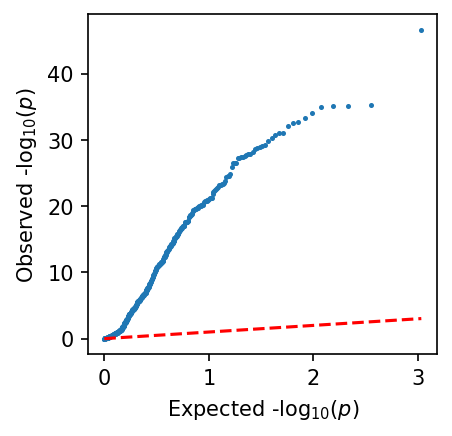

In [13]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
admix.plot.qq(df_plot.pval)
fig.show()

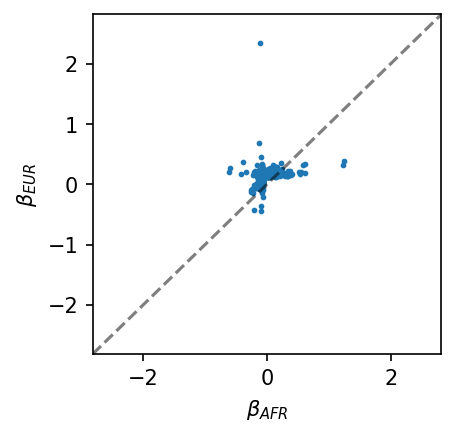

In [14]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
xlim = np.max(np.abs([df_plot.b1.min(), df_plot.b1.max()]))
ylim = np.max(np.abs([df_plot.b2.min(), df_plot.b2.max()]))
lim = max(xlim, ylim) * 1.2

ax.scatter(
    x=df_plot.b1,
    y=df_plot.b2,
    s=3,
)
# sns.scatterplot(data=df_plot, x="b1", y="b2", edgecolor=None, s=3, ax=ax)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.plot([-lim, lim], [-lim, lim], color="black", ls="--", alpha=0.5)
ax.set_xlabel("$\\beta_{AFR}$")
ax.set_ylabel("$\\beta_{EUR}$")

fig.show()